## 子任务1：深度学习方法求解亥姆霍兹方程正问题

亥姆霍兹（Helmholtz）方程是一个描述电磁波的椭圆偏微分方程，经常出现在物理学中的电磁辐射、地震学、声学研究等领域，因此求解 Helmholtz 方程是非常重要的。考虑对如下 Helmholtz 方程进行求解：

$$
\begin{cases}
-\Delta u(x, y) - k^2 u(x, y) = q(x, y), & (x, y) \in \Omega := [-1,1] \times [-1,1], \\
u(x, y) = 0, & (x, y) \in \partial \Omega,
\end{cases}
\tag{1}
$$

其中 $\Delta$ 为拉普拉斯算子，**源项** $q(x, y)$ 为：

$$
q(x, y) = -(a_1 \pi)^2 \sin(a_1 \pi x)\sin(a_2 \pi y)
          - (a_2 \pi)^2 \sin(a_1 \pi x)\sin(a_2 \pi y)
          - k^2 \sin(a_1 \pi x)\sin(a_2 \pi y).
$$

在这个子任务中，对 $a_1 = 1, a_2 = 3, k = 4$，参赛者需要设计和实现深度学习方法对 Helmholtz 方程（1）求解 $u(x, y)$。


显然真解为 $u^*(x, y) = \sin(\pi x) \sin(3 \pi y)$.

In [5]:
"""Backends supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import time
import deepxde as dde
import numpy as np

# =======================
# 配置与超参数
# =======================
# 方程参数
a1, a2, k_val = 1, 3, 4.0

# 训练/测试采样与网络
precision_train = 10     # 每个波长的训练点数（越大越密）
precision_test = 30      # 每个波长的测试点数
hard_constraint = True   # True: 硬约束；False: 软约束（DirichletBC）
weights = 100            # 软约束时的边界损失权重
iterations = 5000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 150
activation = "gelu"    

# 随机种子（可重复性）
dde.config.set_random_seed(2025)

# DeepXDE 后端正弦
sin = dde.backend.sin

# =======================
# PDE 与真解/源项
# =======================
def true_u(x):
    """真解 u*(x,y) = sin(pi x) sin(3 pi y)."""
    return np.sin(np.pi * x[:, 0:1]) * np.sin(3 * np.pi * x[:, 1:2])

def q_src(x):
    """源项 q(x,y)（用于可视化/验证；训练中直接在 PDE 里算）"""
    return (-(a1*np.pi)**2 * np.sin(a1*np.pi*x[:,0:1]) * np.sin(a2*np.pi*x[:,1:2])
            -(a2*np.pi)**2 * np.sin(a1*np.pi*x[:,0:1]) * np.sin(a2*np.pi*x[:,1:2])
            - k_val**2      * np.sin(a1*np.pi*x[:,0:1]) * np.sin(a2*np.pi*x[:,1:2]))

def pde(x, y):
    """
    残差： -u_xx - u_yy - k^2 u - q(x,y) = 0
    """
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    # JAX 后端需要取出第 0 维
    if dde.backend.backend_name == "jax":
        y = y[0]
        dy_xx = dy_xx[0]
        dy_yy = dy_yy[0]

    # q(x,y)
    q = (-(a1*np.pi)**2 * sin(a1*np.pi * x[:, 0:1]) * sin(a2*np.pi * x[:, 1:2])
         -(a2*np.pi)**2 * sin(a1*np.pi * x[:, 0:1]) * sin(a2*np.pi * x[:, 1:2])
         - k_val**2      * sin(a1*np.pi * x[:, 0:1]) * sin(a2*np.pi * x[:, 1:2]))

    return -dy_xx - dy_yy - (k_val**2) * y - q

def boundary(_, on_boundary):
    return on_boundary

def output_transform(x, y):
    """
    硬约束输出变换：
    在边界 x=±1 或 y=±1 处 (1-x^2)(1-y^2)=0，从而 u=0。
    """
    g = (1 - x[:, 0:1]**2) * (1 - x[:, 1:2]**2)
    return g * y

# =======================
# 几何与采样
# =======================
# 区域 [-1,1] x [-1,1]
geom = dde.geometry.Rectangle(xmin=[-1.0, -1.0], xmax=[ 1.0,  1.0])

# 每维训练/测试离散点数：a * precision
nx_train = a1 * precision_train
ny_train = a2 * precision_train
nx_test  = a1 * precision_test
ny_test  = a2 * precision_test

num_domain   = int(nx_train * ny_train)       # 近似内部点数
num_boundary = 2 * (nx_train + ny_train)      # 近似边界点数

# =======================
# 数据集
# =======================
if hard_constraint:
    bcs = []  # 由输出变换保证 u=0
else:
    # 软约束：Dirichlet 边界条件 u=0
    bcs = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary)

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=num_domain,
    num_boundary=num_boundary,
    solution=true_u,
    num_test=int(nx_test * ny_test),
)

# =======================
# 网络与模型
# =======================
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1],
    activation,
    "Glorot uniform",
)

if hard_constraint:
    net.apply_output_transform(output_transform)

model = dde.Model(data, net)

if hard_constraint:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
else:
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=[1.0, float(weights)],  # PDE 残差 + 边界
    )

# =======================
# 训练与效率度量
# =======================
# 参数量
def count_params():
    nparams = 0
    for var in net.parameters:
        shape = var.shape
        p = 1
        for s in shape:
            p *= int(s)
        nparams += p
    return nparams

start_time = time.time()
losshistory, train_state = model.train(iterations=iterations)
train_time = time.time() - start_time

# 训练吞吐量估计
iters_per_sec = iterations / train_time
samples_per_iter = num_domain + num_boundary
samples_per_sec = samples_per_iter * iters_per_sec

# =======================
# 推理速度（在测试网格上）
# =======================
# 生成规则测试网格（与 num_test 一致规模）
xs = np.linspace(-1.0, 1.0, nx_test)
ys = np.linspace(-1.0, 1.0, ny_test)
XX, YY = np.meshgrid(xs, ys, indexing="xy")
Xtest = np.hstack([XX.reshape(-1, 1), YY.reshape(-1, 1)])

t0 = time.time()
Upred = model.predict(Xtest, operator=None)
infer_time = time.time() - t0
points_per_sec = Xtest.shape[0] / infer_time

# 误差评估（相对 L2）
Utrue = true_u(Xtest)
rel_l2 = np.linalg.norm(Upred - Utrue) / np.linalg.norm(Utrue)

# =======================
# 输出与保存
# =======================
print("\n================ 训练完成 ================ ")
print(f"Backend: {dde.backend.backend_name}")
print(f"Domain: [-1,1] x [-1,1]")
print(f"a1={a1}, a2={a2}, k={k_val}")
print(f"Network: FNN({num_dense_layers}x{num_dense_nodes}), activation={activation}")
print(f"Train points (domain,bndry): ({num_domain}, {num_boundary})  |  Test points: {Xtest.shape[0]}")
print(f"Train iterations: {iterations}")

print("\n---- 训练效率 ----")
print(f"Total training time: {train_time:.3f} s")
print(f"Iterations per second: {iters_per_sec:.2f} it/s")
print(f"Samples per iteration (approx): {samples_per_iter}")
print(f"Samples per second (approx): {samples_per_sec:.0f} samples/s")

print("\n---- 推理效率（测试集）----")
print(f"Inference time on {Xtest.shape[0]} points: {infer_time:.4f} s")
print(f"Throughput: {points_per_sec:.0f} pts/s")

print("\n---- 误差 ----")
print(f"L2 relative error (test grid): {rel_l2:.3e}")

# DeepXDE 自带训练曲线保存
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
'compile' took 0.000170 s



Training model...

0         [2.61e+03]    [3.42e+03]    [1.00e+00]    
1000      [1.68e+00]    [2.87e+00]    [2.39e+00]    
2000      [1.51e-01]    [8.89e-01]    [2.39e+00]    
3000      [1.25e-01]    [6.21e-01]    [2.39e+00]    
4000      [9.86e-01]    [1.09e+00]    [2.39e+00]    


KeyboardInterrupt: 

### 实验

#### 第一次实验

1. 采取的tanh作为激活函数，训练了7000次

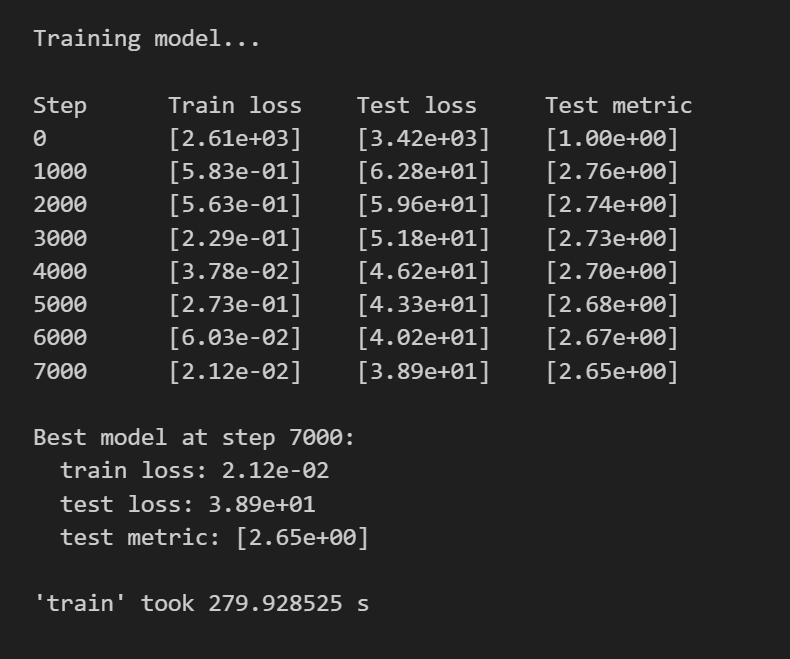

但是训练效果很不好

2. 采取的sin作为激活函数，训练了7000次

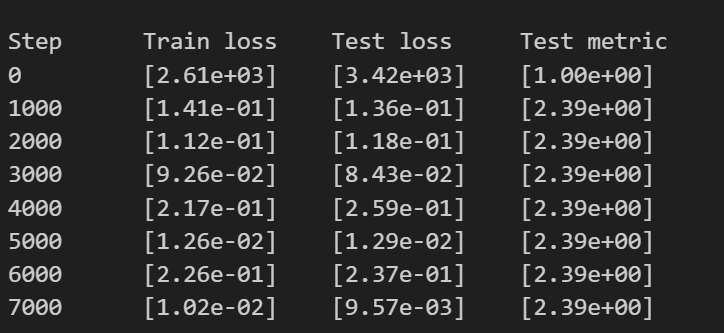

我觉得没必要训练7000次，为什么1000次过后就差不多了，没有量级上的变化，test metric基本上没变化。

3. 采取的sigmoid作为激活函数，训练了5000次

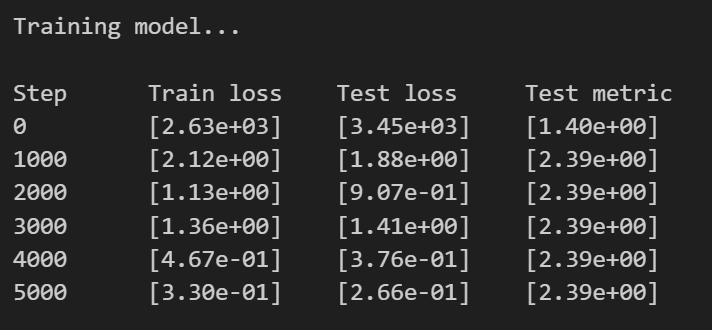

再训练在12000次

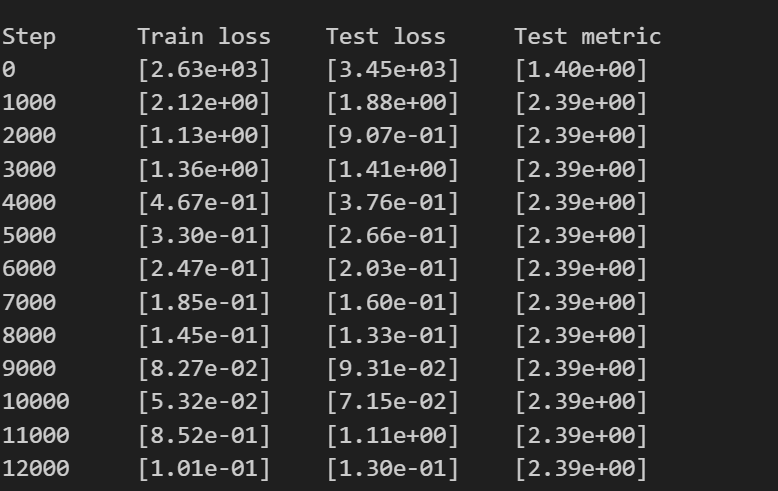

4. 采取的relu作为激活函数，训练了5000次

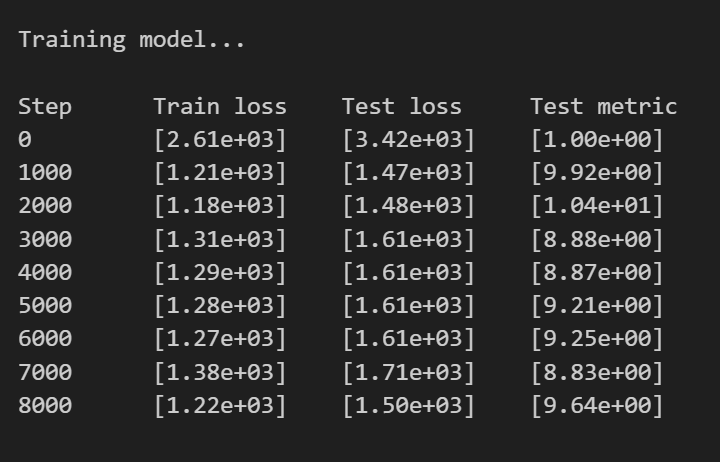

太糟糕了这个函数非常不适合

5. 采取gelu，计算量过于大了

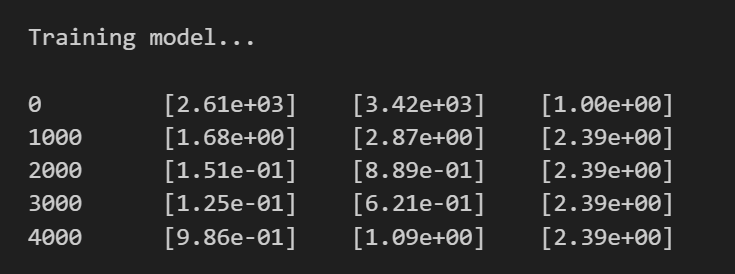



## 子任务2：亥姆霍兹方程高波数快速求解

针对 **子任务1** 中波数 $k$，开发适用高波数求解的高效算法，如求解 $k = 100, 500, 1000$ 下的解 $u(x, y)$。
